# Visual image search
_**Using a Convolutional Neural Net and Elasticsearch k-Nearest Neighbors Index to retrieve visually similar images**_

---

---

## Contents


1. [Background](#Background)
1. [Setup](#Setup)
1. [TensorFlow Model Preparation](#TensorFlow-Model-Preparation)
1. [SageMaker Model Hosting](#Hosting-Model)
1. [Build a KNN Index in Elasticsearch](#ES-KNN)
1. [Evaluate Index Search Results](#Searching-with-ES-k-NN)
1. [Extensions](#Extensions)

## Background

In this notebook, we'll build the core components of a visual image search application. Visual image search is used in interfaces where instead of asking for something by voice or text, you show a photographic example of what you are looking for.

One of the core components of visual image search is a convolutional neural net (CNN) model that generates “feature vectors” representing both a query image and the reference item images to be compared against the query. The reference item feature vectors typically are generated offline and must be stored in a database of some sort, so they can be efficiently searched. For small reference item datasets, it is possible to use a brute force search that compares the query against every reference item. However, this is not feasible for large data sets where brute force search would become prohibitively slow. 

To enable efficient searches for visually similar images, we'll use Amazon SageMaker to generate “feature vectors” from images and use KNN algorithm in Amazon Elasticsearch Service. KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance or cosine similarity(default is Euclidean distance). Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

Here are the steps we'll follow to build the visual image search: After some initial setup, we'll prepare a model using TensorFlow for generating feature vectors, then generate feature vectors of Fashion Images from *__feidegger__*, a *__zalandoresearch__* dataset. Those feature vectors will be imported in Amazon Elasticsearch KNN Index. Next, we'll explore some test image queries, and visualize the results.


In [1]:
#Install tqdm to have progress bar
!pip install tqdm

#install necessary pkg to make connection with elasticsearch domain
# !pip install elasticsearch==8.2.0
!pip install requests
!pip install requests-aws4auth

In [2]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

s3_resource = boto3.resource("s3")
s3 = boto3.client('s3')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
cfn = boto3.client('cloudformation')

def get_cfn_outputs(stackname):
    outputs = {}
    for output in cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']:
        outputs[output['OutputKey']] = output['OutputValue']
    return outputs

## Setup variables to use for the rest of the demo
cloudformation_stack_name = "visual-search"

outputs = get_cfn_outputs(cloudformation_stack_name)

bucket = outputs['s3BucketTraining']
es_host = outputs['esHostName']

outputs

{'esDomainName': 'visual-domain-954w70afzcp9',
 'S3BucketSecureURL': 'https://visual-search-s3buckethosting-1la7ioxynj3lr.s3.amazonaws.com',
 'esHostName': 'search-visual-domain-954w70afzcp9-3tflc6yd7hbtqoezvanzwv2pea.us-east-1.es.amazonaws.com',
 'SageMakerNotebookURL': 'https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/notebook-instances/openNotebook/NotebookInstance-cPuQpaGi2yKs?view=classic',
 's3BucketTraining': 'visual-search-s3buckettraining-1klcski98bm3k',
 's3BucketHostingBucketName': 'visual-search-s3buckethosting-1la7ioxynj3lr'}

### Downloading Zalando Research data

The dataset itself consists of 8732 high-resolution images, each depicting a dress from the available on the Zalando shop against a white-background. 

**Downloading Zalando Research data**: Data originally from here: https://github.com/zalandoresearch/feidegger 

 **Citation:** <br>
 *@inproceedings{lefakis2018feidegger,* <br>
 *title={FEIDEGGER: A Multi-modal Corpus of Fashion Images and Descriptions in German},* <br>
 *author={Lefakis, Leonidas and Akbik, Alan and Vollgraf, Roland},* <br>
 *booktitle = {{LREC} 2018, 11th Language Resources and Evaluation Conference},* <br>
 *year      = {2018}* <br>
 *}*

In [4]:
## Data Preparation

import os 
import shutil
import json
import tqdm
import urllib.request
from tqdm import notebook
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map

images_path = 'data/feidegger/fashion'
filename = 'metadata.json'

my_bucket = s3_resource.Bucket(bucket)

if not os.path.isdir(images_path):
    os.makedirs(images_path)

def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        
#download metadata.json to local notebook
download_metadata('https://raw.githubusercontent.com/zalandoresearch/feidegger/master/data/FEIDEGGER_release_1.2.json')

def generate_image_list(filename):
    metadata = open(filename,'r')
    data = json.load(metadata)
    url_lst = []
    for i in range(len(data)):
        url_lst.append(data[i]['url'])
    return url_lst


def download_image(url):
    print(images_path + '/' + url.split("/")[-1].split("?")[0])
    urllib.request.urlretrieve(url, images_path + '/' + url.split("/")[-1].split("?")[0])
                    
#generate image list            
url_lst = generate_image_list(filename)     

workers = 2 * cpu_count()

#downloading images to local disk
process_map(download_image, url_lst, max_workers=workers)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:46: TqdmWarning: Iterable length 8792 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.


data/feidegger/fashion/dc58460c157b426b817f13e7a2f087c5.jpgdata/feidegger/fashion/c70b2f32a4e844c59796917b811be831.jpg
data/feidegger/fashion/9d83a9a8214a43a1956c9912aa4a6256.jpg
data/feidegger/fashion/0ad3e2d9eed44ea6b2884c97773ce3b3.jpg

data/feidegger/fashion/1297b4e0a7534fac940cca13cac3f4c7.jpg
data/feidegger/fashion/36e6252acced42e5ae4ad0586c4c0b86.jpgdata/feidegger/fashion/1729533d161c48a2accf176cec87c1d2.jpg

data/feidegger/fashion/93e955d396c44f07884ccdcb190f94a4.jpgdata/feidegger/fashion/2d90ba0088c2451084b12c43f05fc66d.jpg

data/feidegger/fashion/fc38cdf561864bd98725fb717bb39590.jpg
data/feidegger/fashion/c44e058172404af693775acbfeb2611c.jpg
data/feidegger/fashion/5b8428600012405283378df92acee811.jpgdata/feidegger/fashion/5368b0c9acc7477d9a6f2bc89c06437e.jpg

data/feidegger/fashion/d463ebc3f06449878e43de012e1b18f9.jpgdata/feidegger/fashion/eaa67046f9394c3c9cec180670fc9d79.jpg

data/feidegger/fashion/6132f9dba4354e7e9d3101a6ad2e0783.jpgdata/feidegger/fashion/cd4f52a243ad4cef82

  0%|          | 0/8792 [00:00<?, ?it/s]

data/feidegger/fashion/31e1bc2de2434364b40483eb20cdd796.jpg
data/feidegger/fashion/612a31a235784b64a1c4db813f30cbc5.jpgdata/feidegger/fashion/c729806643ca420886f4d0bddc2ba2ca.jpg

data/feidegger/fashion/846a84c7f7244b5fbaf4e3d9502d0212.jpg
data/feidegger/fashion/4ccc116281a340d09a96e8da38b32c4e.jpg
data/feidegger/fashion/ddcb1f00c10a412f8090d7b375369351.jpg
data/feidegger/fashion/a2312e642fee417887f4232dc1aa430b.jpgdata/feidegger/fashion/698ca948d9424a979c9a764aaa64e09f.jpg

data/feidegger/fashion/d6682f631b814b389e0d98dccc6b77ff.jpg
data/feidegger/fashion/a3c59e2fbe13431f87ae17ed34b371c1.jpg
data/feidegger/fashion/aafbeac70e4d46e5a1df6e5ee18e5d79.jpg
data/feidegger/fashion/49c4208f67584200b392aab013b3e750.jpgdata/feidegger/fashion/91639abe8cb9404fb0daba6131c15fd0.jpgdata/feidegger/fashion/552055774bec4145a482d45c8a742ccd.jpg


data/feidegger/fashion/0638149c8cc646c1bb8decfe0c4fbc3d.jpg
data/feidegger/fashion/a3fbd33b339d4b069489bf090a6d95a7.jpg
data/feidegger/fashion/db5789479da8479a8

KeyboardInterrupt: 

In [ ]:
# Uploading dataset to S3

files_to_upload = []
dirName = 'data'
for path, subdirs, files in os.walk('./' + dirName):
    path = path.replace("\\","/")
    directory_name = path.replace('./',"")
    cnt=0
    for file in files:
        if file.endswith('?imwidth=400&filter=packshot'):
            print("Skipping ", file)
            cnt+=1
        else:
            files_to_upload.append({
                "filename": os.path.join(path, file),
                "key": directory_name+'/'+file
            })
    print(cnt)
        

def upload_to_s3(file):
#         print(file)
        my_bucket.upload_file(file['filename'], file['key'])
        
#uploading images to s3
process_map(upload_to_s3, files_to_upload, max_workers=workers)

## TensorFlow Model Preparation

We'll use TensorFlow backend to prepare a model for "featurizing" images into feature vectors. TensorFlow has a native Module API, as well as a higher level Keras API. 

We will start with a pretrained model, avoiding spending time and money training a model from scratch. Accordingly, as a first step in preparing the model, we'll import a pretrained model from Keras application. Researchers have experimented with various pretrained CNN architectures with different numbers of layers, discovering that there are several good possibilities.

In this notebook, we'll select a model based on the ResNet architecture, a commonly used choice. Of the various choices for number of layers, ranging from 18 to 152, we'll use 50 layers. This also is a common choice that balances the expressiveness of the resulting feature vectors (embeddings) against computational efficiency (lower number of layers means greater efficiency at the cost of less expressiveness).

In [5]:
import os
import json
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import sagemaker
from PIL import Image
from sagemaker.tensorflow import TensorFlow

In [6]:
# Set the channel first for better performance
from tensorflow.keras import backend
backend.set_image_data_format('channels_first')
print(backend.image_data_format())

channels_first


Now we'll get a reference ResNet50 model which is trained on Imagenet dataset to extract the feature without the actual clssifier. More specifically, we'll use that layer to generate a row vector of floating point numbers as an "embedding" or representation of the features of the image. We'll also save the model as *SavedModel* format under **export/Servo/1** to serve from SageMaker TensorFlow serving API.

In [7]:
#Import Resnet50 model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(3, 224, 224),pooling='avg')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 224, 224) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 230, 230)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 112, 112) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 112, 112) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
#Creating the directory strcture
dirName = 'export/Servo/1'
if not os.path.exists(dirName):
    os.makedirs(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")    

Directory  export/Servo/1  already exists


In [10]:
#Save the model in SavedModel format
model.save('./export/Servo/1/', save_format='tf')

INFO:tensorflow:Assets written to: ./export/Servo/1/assets


In [11]:
#Check the model Signature
!saved_model_cli show --dir ./export/Servo/1/ --tag_set serve --signature_def serving_default

/bin/sh: saved_model_cli: command not found


## SageMaker Model Hosting

After saving the feature extractor model we will deploy the model using Sagemaker Tensorflow Serving api which is a flexible, high-performance serving system for machine learning models, designed for production environments.TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data. We will define **inference.py** to customize the input data to TensorFlow serving API. We also need to add **requirements.txt** file for aditional libraby in the tensorflow serving container.

In [12]:
#check the actual content of inference.py
!pygmentize src/inference.py

import io
import json
import base64
import numpy as np
import tensorflow as tf
from collections import namedtuple
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from PIL import Image

# restricting memory growth
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
if physical_gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in physical_gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(physical_gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

HEIGHT = 224
WIDTH  = 224

Context = namedtuple('Context',
                     'model_name, model_version, method, rest_uri, grpc_uri, '
                     'custom_attributes, request_content_type, a

In [13]:
import tarfile

#zip the model .gz format
model_version = '1'
export_dir = 'export/Servo/' + model_version
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [14]:
#Upload the model to S3
sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')
inputs

's3://sagemaker-us-east-1-926697161658/model/model.tar.gz'

After we upload the model to S3 we will use TensorFlow serving container to host the model. We are using ml.p3.16xlarge instance type. You may need to raise support ticket to increase the Service quotas for SageMaker hosting instance type. We will use this endpoint to generate features and import into ElasticSearch. you can also choose small instance such as "ml.m4.xlarge" to save cost.

In [15]:
#Deploy the model in Sagemaker Endpoint. This process will take ~10 min.
from sagemaker.tensorflow.serving import Model

sagemaker_model = Model(entry_point='inference.py', model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role, framework_version='2.1.0', source_dir='./src' )

predictor = sagemaker_model.deploy(initial_instance_count=3, instance_type='ml.m5.xlarge')



The class sagemaker.tensorflow.serving.Model has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


------!

In [16]:
# get the features for a sample image
from sagemaker.serializers import IdentitySerializer
payload = s3.get_object(Bucket=bucket,Key='data/feidegger/fashion/0000723855b24fbe806c20a1abd9d5dc.jpg')['Body'].read()
predictor.serializer = IdentitySerializer(content_type='application/x-image')
features = predictor.predict(payload)['predictions'][0]

features



[0.0315242968,
 5.84411144,
 0.109719604,
 0.0598737709,
 0.118803054,
 0.0,
 0.368646264,
 0.286989063,
 0.00114812655,
 0.0,
 0.43134892,
 0.0649868399,
 0.0,
 0.0,
 0.614010274,
 0.300491631,
 0.0,
 0.00195597135,
 0.0,
 0.0,
 0.350947022,
 1.7305485,
 0.241731256,
 0.179985732,
 0.154006273,
 0.191015124,
 0.229497209,
 0.315781116,
 0.0,
 0.0436935127,
 0.0,
 0.719145656,
 0.441325754,
 1.92959559,
 1.88576984,
 0.0897719711,
 0.690009356,
 1.65837467,
 0.0659877732,
 0.126879141,
 0.507362843,
 0.0,
 0.0163380951,
 0.0119364187,
 0.710554183,
 0.0604383312,
 0.0383220725,
 1.46830094,
 0.136374876,
 0.445890844,
 0.00544027891,
 0.330714464,
 5.48239803,
 0.0957770646,
 0.653547704,
 0.361813337,
 0.479719281,
 0.419513673,
 0.0750682503,
 0.200365916,
 0.0,
 0.0,
 0.0,
 0.0522172414,
 0.788372457,
 0.103406072,
 0.905329049,
 0.0848973617,
 0.0,
 0.09597186,
 0.00886932202,
 0.598201931,
 0.663985133,
 0.322881728,
 0.0459460542,
 0.528754592,
 0.870049059,
 0.108241454,
 0.2288

## Build a KNN Index in Elasticsearch

KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance or cosine similarity (default is Euclidean distance). Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

KNN requires Elasticsearch 7.1 or later. Full documentation for the Elasticsearch feature, including descriptions of settings and statistics, is available in the Open Distro for Elasticsearch documentation. For background information about the k-nearest neighbors algorithm

In this step we'll get all the features zalando images and import those features into Elastichseach7.4 domain.

In [17]:
#Define some utility function

#return all s3 keys
def get_all_s3_keys(bucket):
    """Get a list of all keys in an S3 bucket."""    
    keys = []

    kwargs = {'Bucket': bucket}
    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            keys.append('s3://' + bucket + '/' + obj['Key'])

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

    return keys

In [24]:
# get all the zalando images keys from the bucket make a list
s3_uris = get_all_s3_keys(bucket)[:100]

In [25]:
# define a function to extract image features
from time import sleep

sm_client = boto3.client('sagemaker-runtime')
ENDPOINT_NAME = predictor.endpoint

def get_predictions(payload):
    return sm_client.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                           ContentType='application/x-image',
                                           Body=payload)

def extract_features(s3_uri):
    key = s3_uri.replace(f's3://{bucket}/', '')
    payload = s3.get_object(Bucket=bucket,Key=key)['Body'].read()
    try:
        response = get_predictions(payload)
    except:
        sleep(0.1)
        response = get_predictions(payload)

    del payload
    response_body = json.loads((response['Body'].read()))
    feature_lst = response_body['predictions'][0]
    
    return s3_uri, feature_lst


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [26]:
# This process cell will take approximately 24-25 minutes on a t3.medium notebook instance
# with 3 m5.xlarge SageMaker Hosted Endpoint instances
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map

workers = 2 * cpu_count()
result = process_map(extract_features, s3_uris, max_workers=workers)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
! /home/ec2-user/anaconda3/envs/tensorflow_p36/bin/pip freeze

In [ ]:
! conda info --envs

In [27]:
# setting up the Elasticsearch connection
# import pkg_resources
# pkg_resources.require("elasticsearch==7.14.0")


from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
region = 'us-east-1' # e.g. us-east-1
service = 'es'
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service, session_token=credentials.token)
es = Elasticsearch(
    hosts = [{'host': es_host, 'port': 443}],
     http_auth=awsauth,
     use_ssl=True,
     verify_certs=True,
     connection_class=RequestsHttpConnection
)

In [28]:
#Define KNN Elasticsearch index maping
knn_index = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
            "zalando_img_vector": {
                "type": "knn_vector",
                "dimension": 2048
            }
        }
    }
}

In [29]:
#Creating the Elasticsearch index
es.indices.create(index="idx_zalando",body=knn_index,ignore=400)
es.indices.get(index="idx_zalando")

{'idx_zalando': {'aliases': {},
  'mappings': {'properties': {'zalando_img_vector': {'type': 'knn_vector',
     'dimension': 2048}}},
  'settings': {'index': {'number_of_shards': '5',
    'provided_name': 'idx_zalando',
    'knn': 'true',
    'creation_date': '1651868415295',
    'number_of_replicas': '1',
    'uuid': 'CkFiiqeGQaGhh2PITNeSwQ',
    'version': {'created': '7040299'}}}}}

In [30]:
# defining a function to import the feature vectors corrosponds to each S3 URI into Elasticsearch KNN index
# This process will take around ~3 min.


def es_import(i):
    es.index(index='idx_zalando',
             body={"zalando_img_vector": i[1], 
                   "image": i[0]}
            )
    
process_map(es_import, result, max_workers=workers)

  0%|          | 0/100 [00:00<?, ?it/s]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Evaluate Index Search Results

In this step we will use SageMaker SDK as well as Boto3 SDK to query the Elasticsearch to retrive the nearest neighbours. One thing to mention **zalando** dataset has pretty good similarity with Imagenet dataset. Now if you hav a very domain speific problem then then you need to train that dataset on top of pretrained feature extractor model such as VGG, Resnet, Xeception, Mobilenet etc and bulid a new feature extractor model.

In [31]:
#define display_image function
def display_image(bucket, key):
    response = s3.get_object(Bucket=bucket,Key=key)['Body']
    img = Image.open(response)
    return display(img)

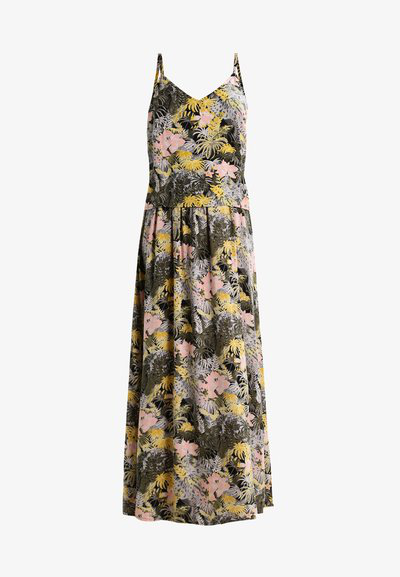

In [33]:
import requests
import random
from PIL import Image
import io
urls = []
# yellow pattern dess
urls.append("https://img01.ztat.net/article/spp-media-p1/3c8812d8b6233a55a5da06b19d780302/dc58460c157b426b817f13e7a2f087c5.jpg?imwidth=400&filter=packshot")
# T shirt kind dress
urls.append("https://img01.ztat.net/article/spp-media-p1/cc59f7e79f34318b9cfdb27fd062c957/5368b0c9acc7477d9a6f2bc89c06437e.jpg?imwidth=400&filter=packshot")
#Dotted pattern dress
urls.append("https://img01.ztat.net/article/spp-media-p1/32c6676765d63a67abdde31f9c0aa304/57394983af674e5f96406d84b619fd9c.jpg?imwidth=400&filter=packshot")

img_bytes = requests.get(random.choice(urls)).content
query_img = Image.open(io.BytesIO(img_bytes))
query_img

###### SageMaker SDK Method

In [34]:
#SageMaker SDK approach
from sagemaker.serializers import IdentitySerializer
predictor.serializer = IdentitySerializer(content_type='application/x-image')
features = predictor.predict(img_bytes)['predictions'][0]

In [35]:
import json
k = 5
idx_name = 'idx_zalando'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'zalando_img_vector': {'vector': features, 'k': k}}}})

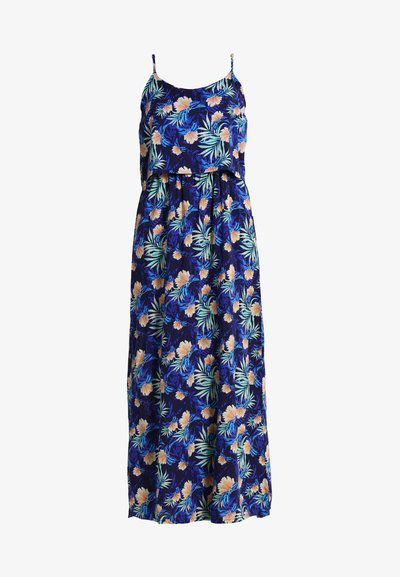

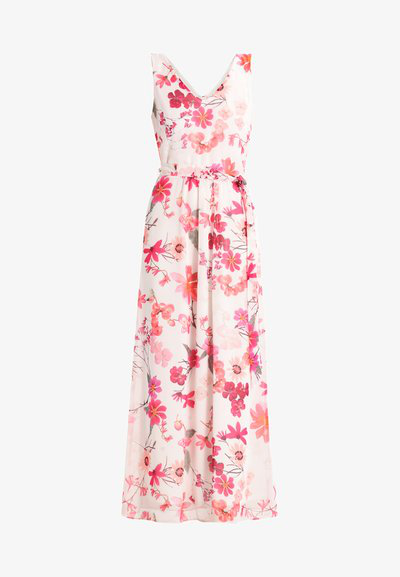

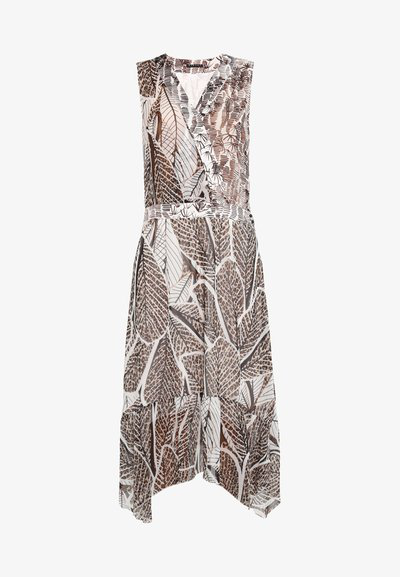

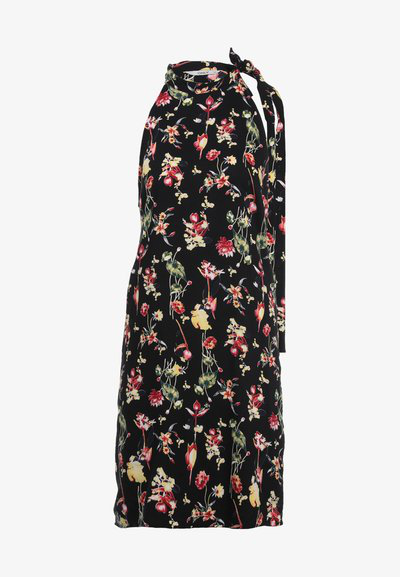

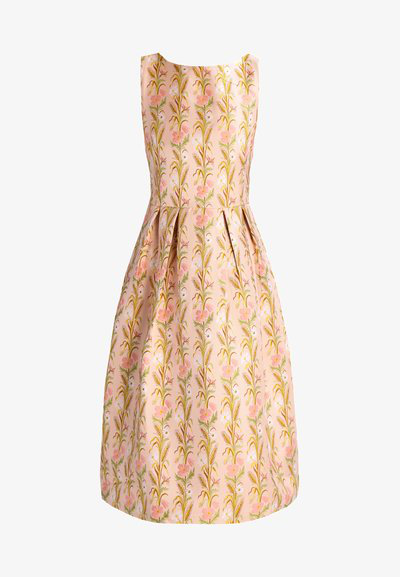

In [36]:
for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace(f's3://{bucket}/','')
    img = display_image(bucket,key)

##### Boto3 Method

In [37]:
client = boto3.client('sagemaker-runtime')
ENDPOINT_NAME = predictor.endpoint # our endpoint name
response = client.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='application/x-image',
                                       Body=img_bytes)

response_body = json.loads((response['Body'].read()))
features = response_body['predictions'][0]



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [38]:
import json
k = 5
idx_name = 'idx_zalando'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'zalando_img_vector': {'vector': features, 'k': k}}}})


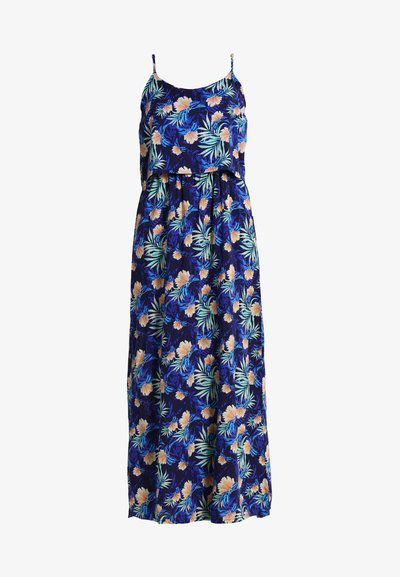

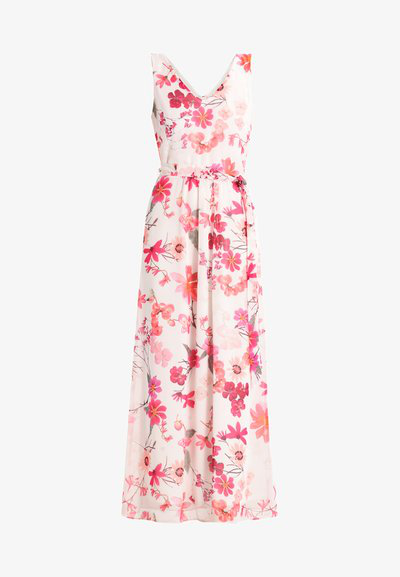

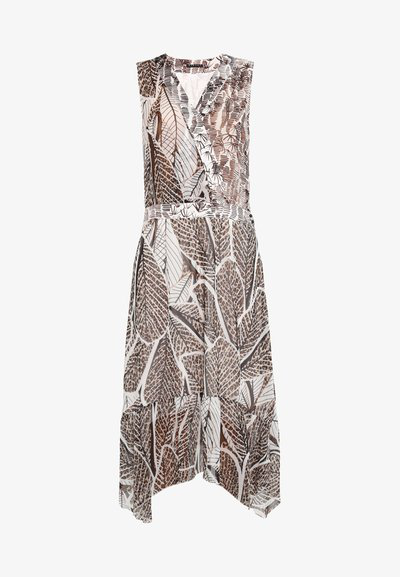

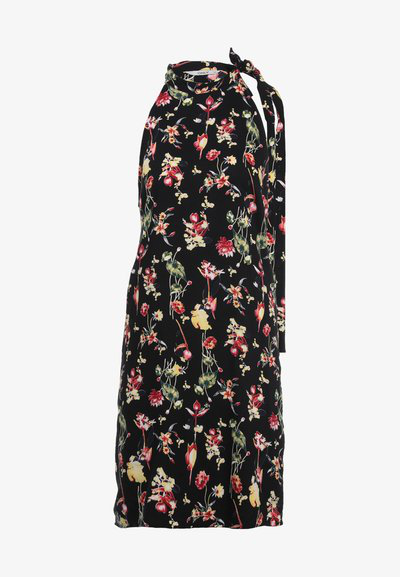

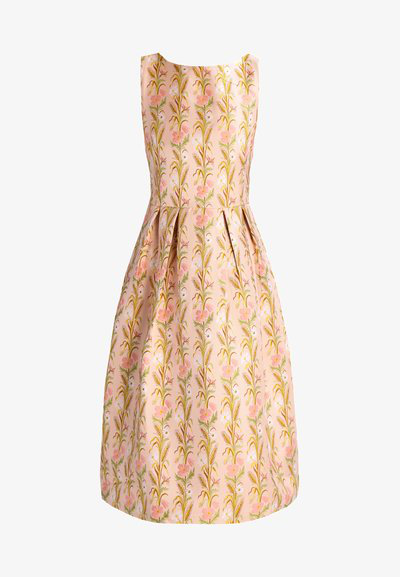

In [39]:
for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace(f's3://{bucket}/','')
    img = display_image (bucket,key)

# Deploying a full-stack visual search application

In [50]:
s3_resource.Object(bucket, 'backend/template.yaml').upload_file('./backend/template.yaml', ExtraArgs={'ACL':'public-read'})


sam_template_url = f'https://{bucket}.s3.amazonaws.com/backend/template.yaml'

# Generate the CloudFormation Quick Create Link

print("Click the URL below to create the backend API for visual search:\n")
print((
    'https://console.aws.amazon.com/cloudformation/home?region=us-east-1#/stacks/create/review'
    f'?templateURL={sam_template_url}'
    '&stackName=vis-search-api'
    f'&param_BucketName={outputs["s3BucketTraining"]}'
    f'&param_DomainName={outputs["esDomainName"]}'
    f'&param_ElasticSearchURL={outputs["esHostName"]}'
    f'&param_SagemakerEndpoint={predictor.endpoint}'
))

FileNotFoundError: [Errno 2] No such file or directory: './backend/template.yaml'

Now that you have a working Amazon SageMaker endpoint for extracting image features and a KNN index on Elasticsearch, you are ready to build a real-world full-stack ML-powered web app. The SAM template you just created will deploy an Amazon API Gateway and AWS Lambda function. The Lambda function runs your code in response to HTTP requests that are sent to the API Gateway.

In [42]:
# Review the content of the Lambda function code.
!pygmentize backend/lambda/app.py

import base64
import json
from os import environ

import boto3
import requests
from urllib.parse import urlparse
from io import BytesIO

from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth

# Global variables that are reused
sm_runtime_client = boto3.client('sagemaker-runtime')
s3_client = boto3.client('s3')


def get_features(sm_runtime_client, sagemaker_endpoint, img_bytes):
    response = sm_runtime_client.invoke_endpoint(
        EndpointName=sagemaker_endpoint,
        ContentType='application/x-image',
        Body=img_bytes)
    response_body = json.loads((response['Body'].read()))
    features = response_body['predictions'][0]

    return features


def get_neighbors(features, es, k_neighbors=3):
    idx_name = 'idx_zalando'
    res = es.search(
        request_timeout=30, index=idx_name,
        body={
            'size': k_neighbors,
            'query': {'knn': {'zalando_img_vector': {'vector': features, 'k': k_neighbors}}}}

### Once the CloudFormation Stack shows CREATE_COMPLETE, proceed to this cell below:

In [49]:
# Save the REST endpoint for the search API to a config file, to be used by the frontend build

import json
api_endpoint = get_cfn_outputs('vis-search-api')['ImageSimilarityApi']

with open('./frontend/src/config/config.json', 'w') as outfile:
    json.dump({'apiEndpoint': api_endpoint}, outfile)

FileNotFoundError: [Errno 2] No such file or directory: './frontend/src/config/config.json'

## Step 2: Deploy frontend services

In [44]:
# add NPM to the path so we can assemble the web frontend from our notebook code

from os import environ

npm_path = ':/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin'

if npm_path not in environ['PATH']:
    ADD_NPM_PATH = environ['PATH']
    ADD_NPM_PATH = ADD_NPM_PATH + npm_path
else:
    ADD_NPM_PATH = environ['PATH']
    
%set_env PATH=$ADD_NPM_PATH

env: PATH=/usr/local/cuda-10.0/bin:/opt/amazon/openmpi/bin:/opt/amazon/efa/bin:/home/ec2-user/anaconda3/condabin:/home/ec2-user/.dl_binaries/bin:/usr/local/cuda/bin:/usr/libexec/gcc/x86_64-amazon-linux/4.8.5:/home/ec2-user/anaconda3/envs/tensorflow_p36/bin:/home/ec2-user/anaconda3/condabin:/opt/amazon/openmpi/bin:/opt/amazon/efa/bin:/home/ec2-user/anaconda3/condabin:/home/ec2-user/.dl_binaries/bin:/usr/local/cuda/bin:/usr/libexec/gcc/x86_64-amazon-linux/4.8.5:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/opt/aws/bin:/opt/aws/bin:/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin


In [45]:
%cd ./frontend/

!npm install

/home/ec2-user/SageMaker/amazon-sagemaker-visual-search/frontend
        ......] | postinstall:arr-union: info lifecycle arr-union@3.1.0~po
> core-js@2.6.11 postinstall /home/ec2-user/SageMaker/amazon-sagemaker-visual-search/frontend/node_modules/babel-runtime/node_modules/core-js
> node -e "try{require('./postinstall')}catch(e){}"

Thank you for using core-js ( https://github.com/zloirock/core-js ) for polyfilling JavaScript standard library!

The project needs your help! Please consider supporting of core-js on Open Collective or Patreon: 
> https://opencollective.com/core-js 
> https://www.patreon.com/zloirock 

Also, the author of core-js ( https://github.com/zloirock ) is looking for a good job -)


> core-js@3.6.5 postinstall /home/ec2-user/SageMaker/amazon-sagemaker-visual-search/frontend/node_modules/core-js
> node -e "try{require('./postinstall')}catch(e){}"


> core-js-pure@3.6.5 postinstall /home/ec2-user/SageMaker/amazon-sagemaker-visual-search/frontend/node_modules/core-js

In [46]:
!npm run-script build


> frontend@0.1.0 build /home/ec2-user/SageMaker/amazon-sagemaker-visual-search/frontend
> react-scripts build

Creating an optimized production build...
Browserslist: caniuse-lite is outdated. Please run:
npx browserslist@latest --update-db
Compiled successfully.

File sizes after gzip:

  194.79 KB  build/static/js/2.385ac3cf.chunk.js
  4.5 KB     build/static/css/2.4a00a097.chunk.css
  2.37 KB    build/static/js/main.7403b478.chunk.js
  770 B      build/static/js/runtime-main.fc75219d.js
  547 B      build/static/css/main.5f361e03.chunk.css

The project was built assuming it is hosted at /.
You can control this with the homepage field in your package.json.

The build folder is ready to be deployed.
You may serve it with a static server:

  npm install -g serve
  serve -s build

Find out more about deployment here:

  bit.ly/CRA-deploy



   ╭───────────────────────────────────────────────────────────────╮
   │                                                               │
   │     

In [47]:
hosting_bucket = f"s3://{outputs['s3BucketHostingBucketName']}"

!aws s3 sync ./build/ $hosting_bucket --acl public-read

upload: build/asset-manifest.json to s3://visual-search-s3buckethosting-1la7ioxynj3lr/asset-manifest.json
upload: build/logo192.png to s3://visual-search-s3buckethosting-1la7ioxynj3lr/logo192.png
upload: build/favicon.ico to s3://visual-search-s3buckethosting-1la7ioxynj3lr/favicon.ico
upload: build/index.html to s3://visual-search-s3buckethosting-1la7ioxynj3lr/index.html
upload: build/precache-manifest.ce61d191d05ebb93fdec26443d48097f.js to s3://visual-search-s3buckethosting-1la7ioxynj3lr/precache-manifest.ce61d191d05ebb93fdec26443d48097f.js
upload: build/logo512.png to s3://visual-search-s3buckethosting-1la7ioxynj3lr/logo512.png
upload: build/manifest.json to s3://visual-search-s3buckethosting-1la7ioxynj3lr/manifest.json
upload: build/service-worker.js to s3://visual-search-s3buckethosting-1la7ioxynj3lr/service-worker.js
upload: build/static/css/2.4a00a097.chunk.css.map to s3://visual-search-s3buckethosting-1la7ioxynj3lr/static/css/2.4a00a097.chunk.css.map
upload: build/static/css/mai

## Step 3: Browse your frontend service, and upload an image

In [48]:
print('Click the URL below:\n')
print(outputs['S3BucketSecureURL'] + '/index.html')

Click the URL below:

https://visual-search-s3buckethosting-1la7ioxynj3lr.s3.amazonaws.com/index.html


You should see the following page:

![Website](pi3small.png)

On the website, try pasting the following URL in the URL text field.

`https://i4.ztat.net/large/VE/12/1C/14/8K/12/VE121C148-K12@10.jpg`

## Extensions

We have used pretrained Resnet50 model which is trained on Imagenet dataset. Now based on your use-case you can fine tune any pre-trained models, such as VGG, Inception, and MobileNet with your own dataset and host the model in Amazon SageMaker.

You can also use Amazon SageMaker Batch transform job to have a bulk feaures extracted from your stored S3 images and then you can use AWS Glue to import that data into Elasticeearch domain.


### Cleanup

Make sure that you stop the notebook instance, delete the Amazon SageMaker endpoint and delete the Elasticsearch domain to prevent any additional charges.

In [ ]:
# Delete the endpoint
predictor.delete_endpoint()

In [ ]:
# Empty S3 Contents
training_bucket_resource = s3_resource.Bucket(bucket)
training_bucket_resource.objects.all().delete()

hosting_bucket_resource = s3_resource.Bucket(outputs['s3BucketHostingBucketName'])
hosting_bucket_resource.objects.all().delete()